In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, Input, Flatten, BatchNormalization
from sklearn.model_selection import train_test_split

In [2]:
import time, datetime
from fyers_apiv3 import fyersModel
import authenticator
client_id = "ZHQ4IJL7TI-100"
access_token = authenticator.authenticate()

fyers = fyersModel.FyersModel(client_id=client_id, is_async=False, token=access_token, log_path="")
market_status = fyers.market_status()

"Market: " + market_status["marketStatus"][1]['status']

'Market: CLOSED'

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from indicators.syncind import SyncInd
from indicators.classic import SMA, Alligator, SmoothMA, RSI, MACD, ATR, WMA, EMA, RMA, VolumeROC, KAMA
from indicators.candle import OHLC
from indicators import epoch_to_time

In [5]:
date_yesterday = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
date_100_p = (datetime.datetime.now() - datetime.timedelta(days=100)).strftime("%Y-%m-%d")
date_yesterday, date_100_p

('2025-03-11', '2024-12-02')

In [6]:
symbol = "NSE:NIFTY50-INDEX"
resolution_1 = "1"

response_1 = fyers.history(data={
                                "symbol": symbol,
                                "resolution": resolution_1,
                                "date_format": "1",
                                "range_from": date_100_p,
                                "range_to": date_yesterday,
                                "cont_flag": "1"
                        })



In [7]:
def remove_duplicates(resp_candels):
    date_temp = []
    final_candles_list = []
    for i in resp_candels:
        if i[0] not in date_temp:
            final_candles_list.append(i)
            date_temp.append(i[0])
    del date_temp
    return final_candles_list


final_candles_list_1 = remove_duplicates(response_1['candles'])
len(final_candles_list_1)

26625

In [8]:
candles_1 = np.array(final_candles_list_1)
candles_1.shape

(26625, 6)

In [9]:
sync_1 = SyncInd(
    SMA(5),
    Alligator(show_jaw=False, show_teeth=False),
    # EMA(),
    KAMA(highlight=True),
)

for c in candles_1:
    sync_1.append(c)
sync_1.data().shape


(26625, 10)

In [10]:
X, y = [], []
start_ind = 1 # should be 1 or greater than 1; otherwise logic assumes first candle as the last candle
back_look = 5
sync_data = sync_1.data()

def append_to_final_data(data):
    for ind, i in enumerate(data[start_ind : -back_look]):
        temp = []
        first_candle = data[start_ind+ind-1]
        
        last_candle = data[start_ind+ind+back_look-1]
        if epoch_to_time(first_candle[0]).split(" ")[0] != epoch_to_time(last_candle[0]).split(" ")[0]:
            # print(f'''day change detected: {epoch_to_time(first_candle[0]).split(" ")[0]} to {epoch_to_time(last_candle[0]).split(" ")[0]}''')
            continue
            
        for j in data[start_ind+ind : start_ind+ind+back_look]:
            temp.append([round(a, 2) for a in (j[1:]-first_candle[1:]).tolist()[5:]])    
        y.append([round(a, 2) for a in (data[start_ind+ind+back_look][1:] - first_candle[1:]).tolist()[5:]])
        X.append(temp)


append_to_final_data(sync_data[100:])

X = np.array(X, dtype=np.float16)
y = np.array(y, dtype=np.float16)

"X.shape", X.shape, "y.shape", y.shape

('X.shape', (26169, 5, 4), 'y.shape', (26169, 4))

In [11]:
X[0:2]

array([[[-1.46, -2.14, -0.11,  0.  ],
        [-2.9 , -3.13, -0.79,  0.  ],
        [-6.62, -4.36, -1.11,  0.  ],
        [-6.65, -4.02, -1.4 ,  0.  ],
        [-3.83, -3.28, -1.45,  0.  ]],

       [[-1.44, -0.99, -0.69,  0.  ],
        [-5.16, -2.22, -1.  ,  0.  ],
        [-5.19, -1.88, -1.29,  0.  ],
        [-2.37, -1.14, -1.34,  0.  ],
        [ 0.12, -0.09, -1.38,  0.  ]]], dtype=float16)

In [12]:
X[1:2]

array([[[-1.44, -0.99, -0.69,  0.  ],
        [-5.16, -2.22, -1.  ,  0.  ],
        [-5.19, -1.88, -1.29,  0.  ],
        [-2.37, -1.14, -1.34,  0.  ],
        [ 0.12, -0.09, -1.38,  0.  ]]], dtype=float16)

In [13]:
split_len = 20000
X_train, X_test = X[:split_len], X[split_len:]
y_train, y_test = y[:split_len], y[split_len:]
"X_train.shape", X_train.shape, "X_test.shape", X_test.shape, "y_train.shape", y_train.shape, "y_test.shape", y_test.shape

('X_train.shape',
 (20000, 5, 4),
 'X_test.shape',
 (6169, 5, 4),
 'y_train.shape',
 (20000, 4),
 'y_test.shape',
 (6169, 4))

In [14]:
model = Sequential()
model.add(Input(shape=(5, 4)))
model.add(LSTM(200, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(4))
# model.add(Reshape((1, 4)))
model.compile(optimizer='adam', loss='mse')

In [15]:
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.2)

Epoch 1/300
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 89.2663 - val_loss: 21.4364
Epoch 2/300
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 24.2277 - val_loss: 12.4204
Epoch 3/300
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 19.3752 - val_loss: 10.0589
Epoch 4/300
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 15.4461 - val_loss: 8.1728
Epoch 5/300
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 12.8988 - val_loss: 6.7027
Epoch 6/300
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 9.8776 - val_loss: 6.7636
Epoch 7/300
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 8.4658 - val_loss: 5.2603
Epoch 8/300
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 9.7082 - val_loss: 6.4338
Epoch 9/300
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 7.9692 - val_loss: 5.3235
Epoch 10/300
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 7.5250 - val_loss: 4.9937
Epoch 11/300
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 7.0117 - val_loss: 5.1646
Epoch 12/300
500/500 ━━━━━━━━━━━━

KeyboardInterrupt: 

In [16]:
y_pred = model.predict(X_test)
y_pred

193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[-12.635516  ,  -3.6177769 ,   0.8588139 ,  -0.59187025],
       [-14.1089945 ,  -3.3716898 ,   0.11456883,  -0.17935851],
       [-12.713365  ,  -5.32252   ,  -0.26957914,  -1.060256  ],
       ...,
       [  4.249466  ,   4.747753  ,   3.6029823 ,  -0.08603287],
       [  3.824513  ,   4.3852777 ,   2.7685053 ,  -0.20733084],
       [  8.616429  ,   7.3478217 ,   4.636607  ,  -0.0492467 ]],
      dtype=float32)

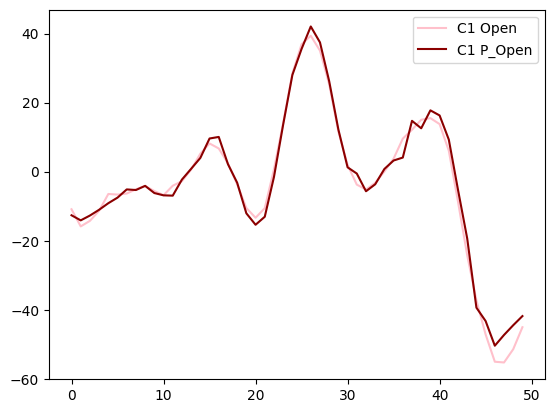

In [17]:
plt.plot(y_test[:50, 0], label='C1 Open', color="pink")
plt.plot(y_pred[:50, 0], label='C1 P_Open', color="darkred")
plt.legend()
plt.show()

In [18]:
model.save("Mar_11_01.keras")

In [19]:
y_pred[:50, 0].shape

(50,)

In [20]:
print("Actual\t\tPredicted\tError")
print("-"*40)
error_list = []
for actual, predicted in zip(y_pred, y_test):
    error = round(float((actual-predicted)[0]), 2)
    print(f"{round(float(actual[0]), 2)}\t\t{round(float(predicted[0]), 2)}\t\t{error}")
    error_list.append(error)

Actual		Predicted	Error
----------------------------------------
-12.64		-10.89		-1.74
-14.11		-15.86		1.75
-12.71		-14.25		1.54
-11.04		-11.33		0.29
-9.14		-6.46		-2.67
-7.52		-6.64		-0.88
-5.14		-6.34		1.2
-5.32		-5.11		-0.21
-4.11		-4.14		0.03
-6.19		-5.6		-0.59
-6.86		-6.82		-0.04
-6.95		-4.08		-2.87
-2.29		-2.76		0.47
0.83		0.62		0.21
3.98		5.21		-1.23
9.61		8.17		1.44
10.06		6.72		3.34
2.17		2.4		-0.23
-3.2		-3.65		0.45
-12.07		-10.53		-1.54
-15.39		-13.35		-2.03
-13.06		-10.58		-2.49
-1.53		0.7		-2.23
13.65		14.08		-0.43
28.01		28.44		-0.43
35.56		36.91		-1.35
42.06		39.38		2.69
37.45		35.06		2.39
26.21		25.33		0.88
12.2		11.63		0.57
1.26		1.95		-0.69
-0.54		-3.75		3.21
-5.67		-5.17		-0.5
-3.66		-3.24		-0.42
0.78		0.06		0.72
3.23		3.77		-0.54
4.08		9.57		-5.49
14.72		12.14		2.58
12.56		15.03		-2.47
17.76		15.51		2.25
16.29		13.78		2.51
9.29		6.06		3.23
-5.27		-8.7		3.43
-19.37		-24.25		4.88
-39.4		-37.28		-2.12
-43.28		-47.16		3.87
-50.42		-55.06		4.64
-47.31		-55.28		7.97
-44.4

In [21]:
print("Max\tMin\tMean\tP_err\tN_err\tTotal")
print("-"*45)
error_offset_pos = 5
error_offset_neg = 5
print(f"{max(error_list)}\t{min(error_list)}\t{round(sum(error_list)/len(error_list), 2)}\t{len([a for a in error_list if a > error_offset_pos])}\t{len([a for a in error_list if a < -error_offset_neg])}\t{len(error_list)}")

Max	Min	Mean	P_err	N_err	Total
---------------------------------------------
31.38	-20.79	0.12	104	47	6169
